In [3]:
# You will need PyBaMM to run this script
%pip install pybamm==24.1

Note: you may need to restart the kernel to use updated packages.


In [3]:
from TDGSA import simulator, distribution, time_dependent_sensitivity_analysis

import pybamm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

scale_factor = 4 # 10 works

PCE_ORDER = 6
NUM_SAMPLES = 4620  # choose optimal number of samples for each order

## model setup
def battery_model(params):
    options = {'surface form': 'differential'}
    dfn = pybamm.lithium_ion.DFN(options=options)
    model_params = dfn.default_parameter_values
    # import drive cycle from file
    drive_cycle = pd.read_csv(
        "~/.local/lib/python3.10/site-packages/pybamm/input/drive_cycles/US06.csv", comment="#", header=None
    ).to_numpy()
    # create interpolant
    current_interpolant = pybamm.Interpolant(drive_cycle[:, 0], drive_cycle[:, 1]/scale_factor, pybamm.t)
    # set drive cycle
    model_params["Current function [A]"] = current_interpolant  
    # set param values
    model_params["Negative electrode porosity"] = params[0]
    model_params["Positive electrode porosity"] = params[1]
    model_params["Negative electrode diffusivity [m2.s-1]"] = params[2]
    model_params["Positive electrode diffusivity [m2.s-1]"] = params[3]
    model_params["Negative particle radius [m]"] = params[4]
    model_params["Positive particle radius [m]"] = params[5]
    
    sim_US06_1 = pybamm.Simulation(
    dfn, parameter_values=model_params, solver=pybamm.CasadiSolver(mode="fast")
    )
    sol_US06_1 = sim_US06_1.solve(drive_cycle[:, 0])
    t_sol = sol_US06_1["Time [s]"].entries
    V_sol = sol_US06_1["Voltage [V]"](t_sol)
    return V_sol
    

/home/elia/TDGSA/TDGSA/utils.py:12: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


Text(0, 0.5, 'Voltage / V')

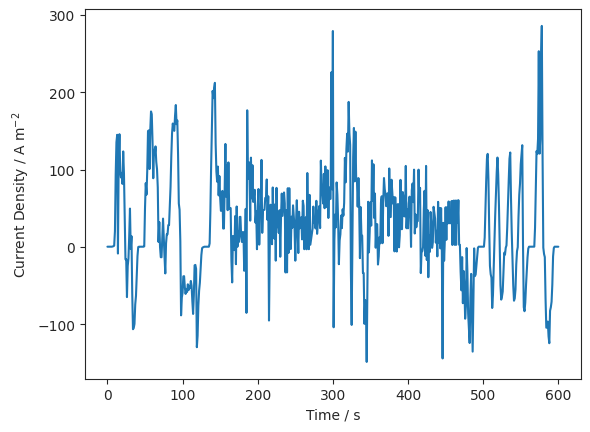

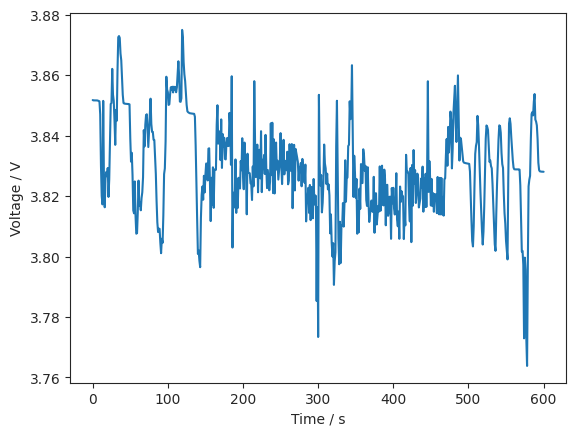

In [5]:
options = {'surface form': 'differential'}
dfn = pybamm.lithium_ion.DFN(options=options)
model_params = dfn.default_parameter_values
# import drive cycle from file
drive_cycle = pd.read_csv(
    "~/.local/lib/python3.10/site-packages/pybamm/input/drive_cycles/US06.csv", comment="#", header=None
).to_numpy()
# create interpolant
current_interpolant = pybamm.Interpolant(drive_cycle[:, 0], drive_cycle[:, 1]/scale_factor, pybamm.t)
# set drive cycle
model_params["Current function [A]"] = current_interpolant

def j0_neg(c_e, c_s_surf, c_s_max, T):
    return 96485.3321 * 1e-10 * c_e**0.5 * c_s_surf**0.5 * (c_s_max - c_s_surf)**0.5
    
def j0_pos(c_e, c_s_surf, c_s_max, T):
    return 96485.3321 * 1e-10 * c_e**0.5 * c_s_surf**0.5 * (c_s_max - c_s_surf)**0.5

# set param values
model_params["Negative electrode porosity"] = 0.3
model_params["Positive electrode porosity"] = 0.4
model_params["Negative electrode diffusivity [m2.s-1]"] = 1e-15
model_params["Positive electrode diffusivity [m2.s-1]"] = 1e-12
model_params["Negative particle radius [m]"] = 0.8e-5
model_params["Positive particle radius [m]"] = 1e-5
model_params['Negative electrode exchange-current density [A.m-2]'] = j0_neg
model_params['Positive electrode exchange-current density [A.m-2]'] = j0_pos


sim_US06_1 = pybamm.Simulation(
dfn, parameter_values=model_params, solver=pybamm.CasadiSolver(mode="fast")
)
sol_US06_1 = sim_US06_1.solve()
t_sol = sol_US06_1["Time [s]"].entries
V_sol = sol_US06_1["Voltage [V]"](t_sol)

sns.set_style("ticks")
plt.figure()
plt.plot(drive_cycle[:,0], drive_cycle[:,1]/(model_params["Electrode height [m]"]*model_params["Electrode width [m]"]))
plt.xlabel("Time / s")
plt.ylabel("Current Density / A m$^{-2}$")

plt.figure()
plt.plot(t_sol, V_sol)
plt.xlabel("Time / s")
plt.ylabel("Voltage / V")

In [7]:
print(t_sol[1]-t_sol[0])
print(len(t_sol))

1.0
601


In [8]:
print(model_params["Electrode height [m]"]*model_params["Electrode width [m]"])

0.028359000000000002


In [3]:
## Define parameter distribution

num_samples = NUM_SAMPLES

my_dist_dict = {
    r"$\Phi_{neg}$": ("uniform", [0.25, 0.5]),
    r"$\Phi_{pos}$": ("uniform", [0.2, 0.65]),
    r"$D_{s,neg}$": ("loguniform", np.log([1e-15, 1e-11])),
    r"$D_{s,pos}$": ("loguniform", np.log([1e-18, 1e-12])),
    r"$R_{neg}$": ("uniform", [0.2e-5, 1.2e-5]),
    r"$R_{pos}$": ("uniform", [0.1e-5, 1e-5])
}

my_distribution = distribution(my_dist_dict)
my_simulator = simulator(battery_model, my_distribution, t_sol)

my_tdsa = time_dependent_sensitivity_analysis(my_simulator, my_distribution)

my_params, my_output = my_tdsa.sample_params_and_run_simulator(num_samples)

Sampling parameters ...

Running simulator ...



  0%|          | 16/4620 [00:10<59:05,  1.30it/s]

KeyboardInterrupt: 

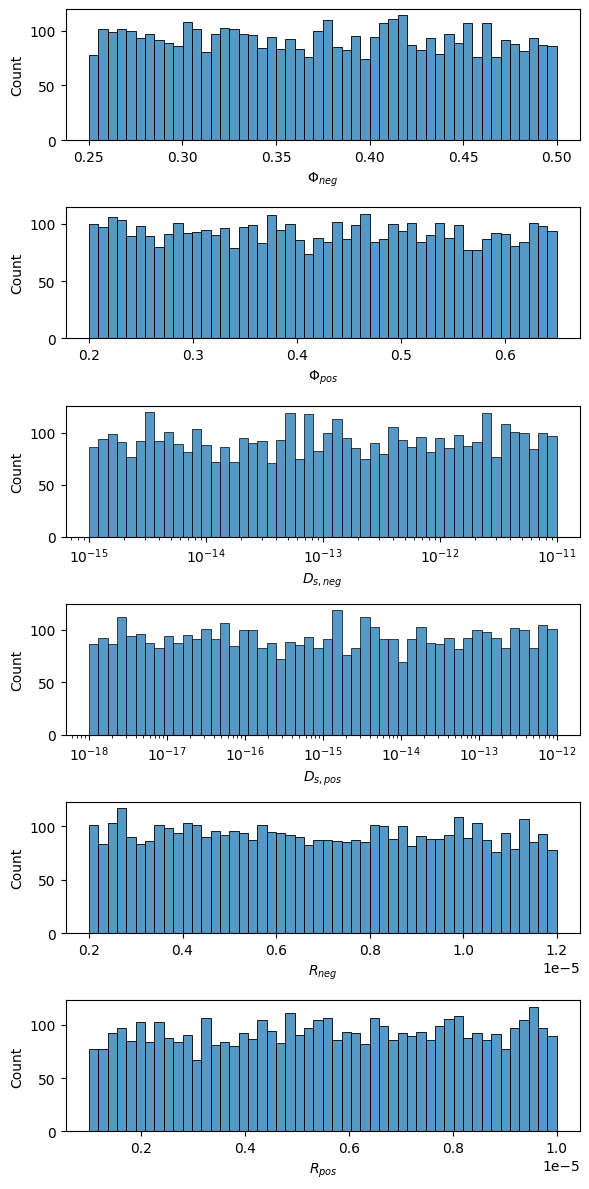

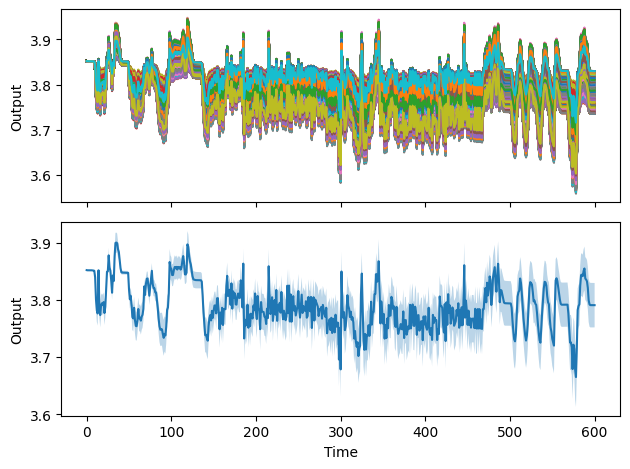

In [ ]:
## Plot parameters
my_tdsa.plot("sampled_parameters")

## Plot output
my_tdsa.plot("simulator_output")

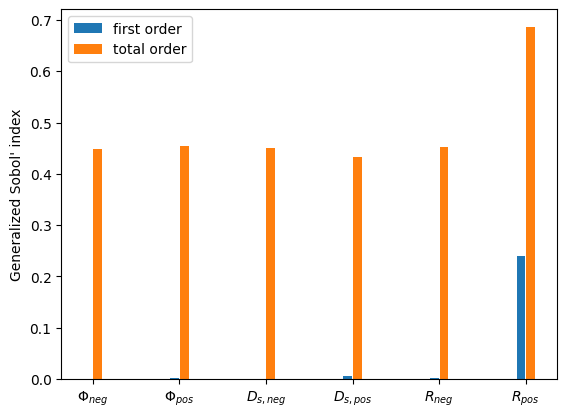

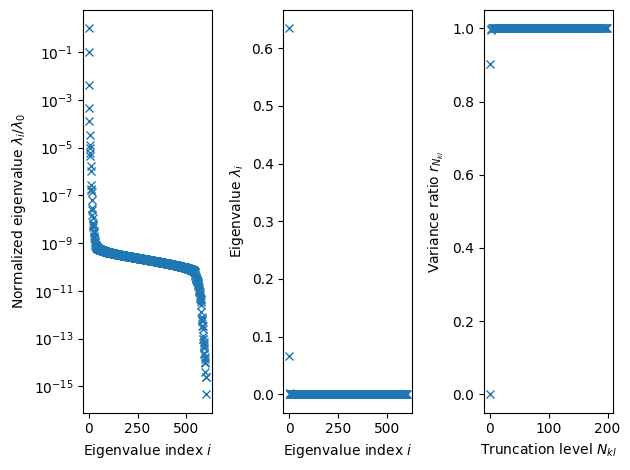

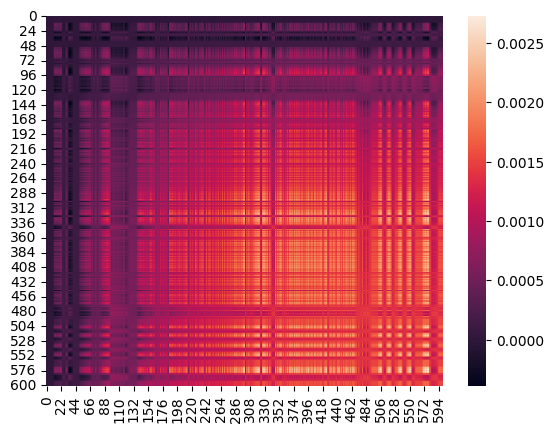

In [ ]:
#===============================================================================#
# Compute the time-dependent sensitivity indices using 'KL'
#===============================================================================#

sobol_indices_KL = my_tdsa.compute_sobol_indices("KL")

my_tdsa.plot("sobol_indices")

my_tdsa.plot("eigenvalue_spectrum")

my_tdsa.plot("covariance_matrix")

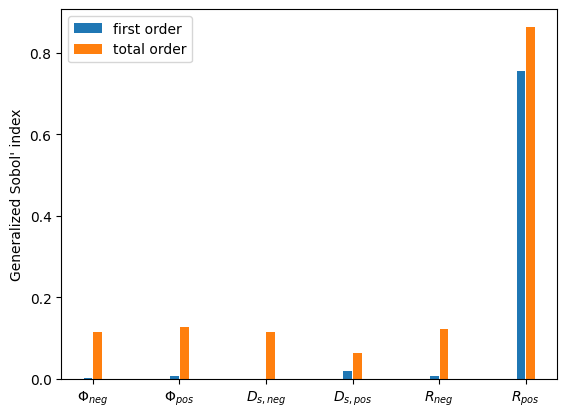

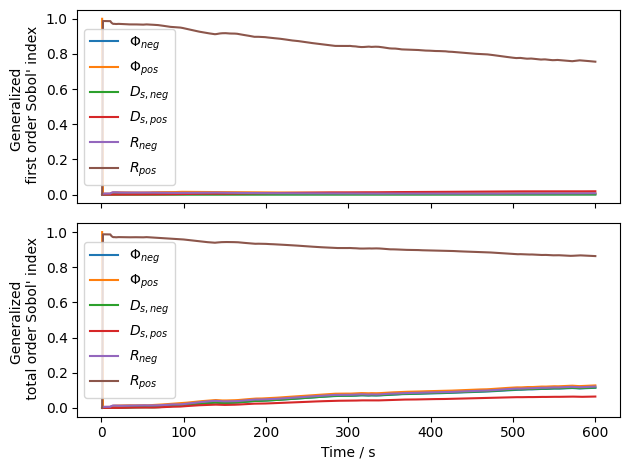

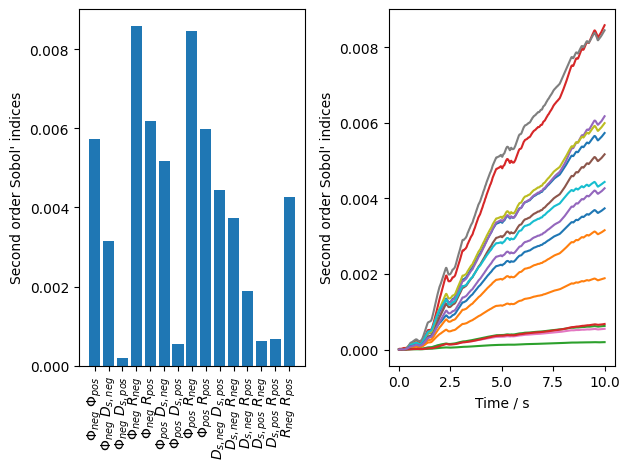

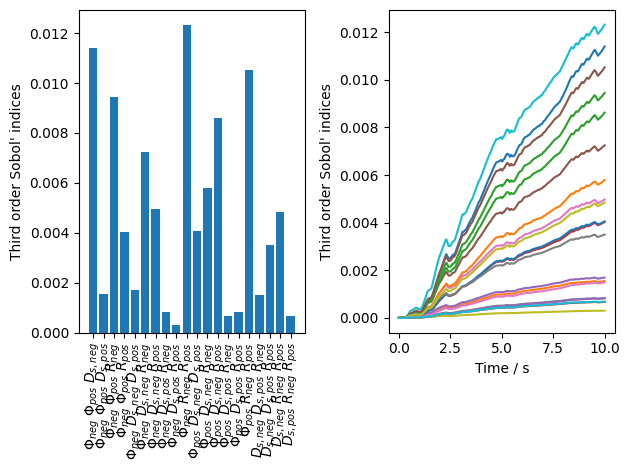

In [ ]:
#===============================================================================#
# Compute the time-dependent sensitivity indices using 'PCE'
#===============================================================================#

sobol_indices_PCE = my_tdsa.compute_sobol_indices("PCE")

my_tdsa.plot("sobol_indices")

my_tdsa.plot("time_dependent_sobol_indices")

second_order_sobol_indices_PCE, param_combinations_sec = my_tdsa.compute_second_order_sobol_indices("PCE")
third_order_sobol_indices_PCE, param_combinations_third = my_tdsa.compute_third_order_sobol_indices("PCE")
second_order_sobol_indices_KL, param_combinations_sec = my_tdsa.compute_second_order_sobol_indices("KL")
third_order_sobol_indices_KL, param_combinations_third = my_tdsa.compute_third_order_sobol_indices("KL")

my_tdsa.plot("higher_order_sobol_indices")

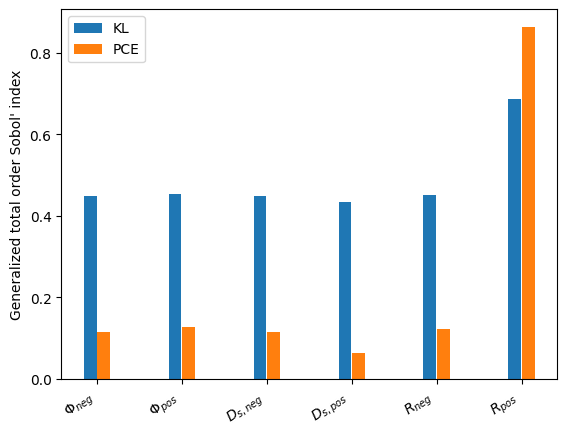

In [ ]:
fig, ax = plt.subplots()
x = np.arange(len(my_tdsa.param_names))
ax.bar(x-0.08, sobol_indices_KL["total"], width=0.15, label="KL")
ax.bar(x+0.08, sobol_indices_PCE["total"], width=0.15, label="PCE")
ax.set_xticks(x, my_tdsa.param_names, rotation=35, ha="right")
ax.set_ylabel("Generalized total order Sobol' index")
ax.legend()

In [ ]:
num_rounds = 3
num_samples = NUM_SAMPLES

sobol_indices_total_KL = np.zeros((num_rounds, len(my_tdsa.param_names)))
sobol_indices_first_KL = np.zeros((num_rounds, len(my_tdsa.param_names)))
sobol_indices_total_PCE = np.zeros((num_rounds, len(my_tdsa.param_names)))
sobol_indices_first_PCE = np.zeros((num_rounds, len(my_tdsa.param_names)))
sobol_indices_second_PCE = np.zeros((num_rounds, len(param_combinations_sec)))
sobol_indices_third_PCE = np.zeros((num_rounds, len(param_combinations_third)))
sobol_indices_second_KL = np.zeros((num_rounds, len(param_combinations_sec)))
sobol_indices_third_KL = np.zeros((num_rounds, len(param_combinations_third)))

for i in range(num_rounds):
    my_params = my_simulator.generate_params(num_samples)
    my_output = my_simulator.generate_output(my_params)
    
    my_tdsa = time_dependent_sensitivity_analysis(my_simulator, my_distribution)
    
    sobol_indices_roundwise_KL = my_tdsa.compute_sobol_indices("KL", PCE_order=PCE_ORDER, num_timesteps_quadrature=601)
    sobol_indices_roundwise_PCE = my_tdsa.compute_sobol_indices("PCE", PCE_order=PCE_ORDER, num_timesteps_quadrature=601)
    
    sobol_indices_roundwise_second_order_PCE, _, _ = my_tdsa.compute_second_order_sobol_indices("PCE")
    sobol_indices_roundwise_third_order_PCE, _, _ = my_tdsa.compute_third_order_sobol_indices("PCE")
    sobol_indices_roundwise_second_order_KL, _, _ = my_tdsa.compute_second_order_sobol_indices("KL")
    sobol_indices_roundwise_third_order_KL, _, _ = my_tdsa.compute_third_order_sobol_indices("KL")
    
    sobol_indices_total_KL[i, :] = sobol_indices_roundwise_KL["total"]
    sobol_indices_first_KL[i, :] = sobol_indices_roundwise_KL["first"]
    sobol_indices_total_PCE[i, :] = sobol_indices_roundwise_PCE["total"]
    sobol_indices_first_PCE[i, :] = sobol_indices_roundwise_PCE["first"]
    
    sobol_indices_second_PCE[i, :] = sobol_indices_roundwise_second_order_PCE
    sobol_indices_third_PCE[i, :] = sobol_indices_roundwise_third_order_PCE
    sobol_indices_second_KL[i, :] = sobol_indices_roundwise_second_order_KL
    sobol_indices_third_KL[i, :] = sobol_indices_roundwise_third_order_KL
    
sobol_indices_total_KL_mean = np.mean(sobol_indices_total_KL, axis=0)
sobol_indices_first_KL_mean = np.mean(sobol_indices_first_KL, axis=0)
sobol_indices_total_KL_std = np.std(sobol_indices_total_KL, axis=0)
sobol_indices_first_KL_std = np.std(sobol_indices_first_KL, axis=0)

sobol_indices_total_PCE_mean = np.mean(sobol_indices_total_PCE, axis=0)
sobol_indices_first_PCE_mean = np.mean(sobol_indices_first_PCE, axis=0)
sobol_indices_total_PCE_std = np.std(sobol_indices_total_PCE, axis=0)
sobol_indices_first_PCE_std = np.std(sobol_indices_first_PCE, axis=0)

sobol_indices_second_PCE_mean = np.mean(sobol_indices_second_PCE, axis=0)
sobol_indices_third_PCE_mean = np.mean(sobol_indices_third_PCE, axis=0)
sobol_indices_second_PCE_std = np.std(sobol_indices_second_PCE, axis=0)
sobol_indices_third_PCE_std = np.std(sobol_indices_third_PCE, axis=0)

sobol_indices_second_KL_mean = np.mean(sobol_indices_second_PCE, axis=0)
sobol_indices_third_KL_mean = np.mean(sobol_indices_third_PCE, axis=0)
sobol_indices_second_KL_std = np.std(sobol_indices_second_PCE, axis=0)
sobol_indices_third_KL_std = np.std(sobol_indices_third_PCE, axis=0)


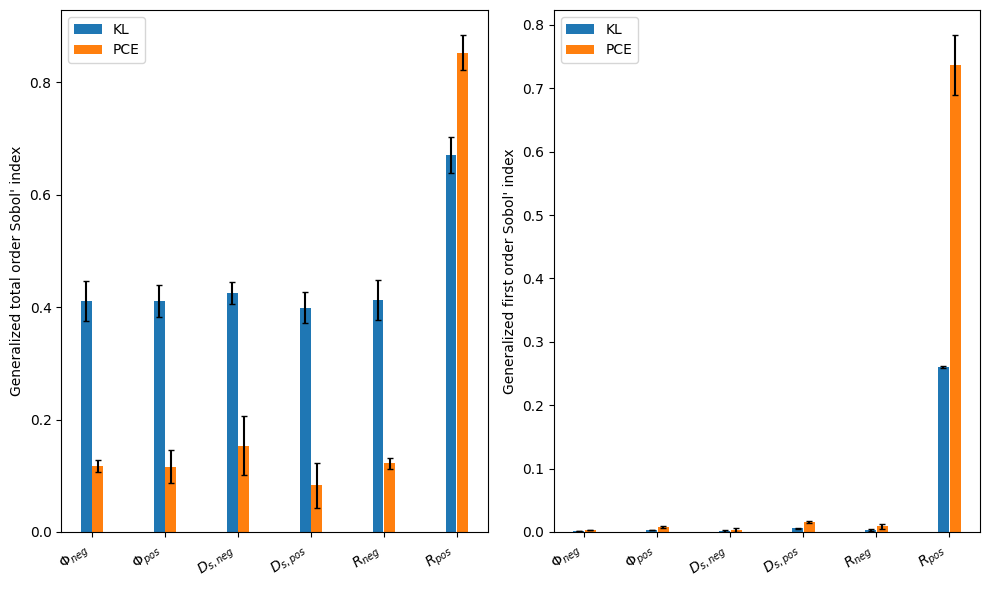

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(10,6))
x = np.arange(my_tdsa.num_params)
ax[0].bar(x-0.08, sobol_indices_total_KL_mean, width=0.15, label="KL")
ax[0].errorbar(x-0.08, sobol_indices_total_KL_mean, yerr=sobol_indices_total_KL_std, capsize=2.5, elinewidth=1.5, markeredgewidth=1, color="black", linestyle="None")
ax[0].bar(x+0.08, sobol_indices_total_PCE_mean, width=0.15, label="PCE")
ax[0].errorbar(x+0.08, sobol_indices_total_PCE_mean, yerr=sobol_indices_total_PCE_std, capsize=2.5, elinewidth=1.5, markeredgewidth=1, color="black", linestyle="None")
ax[0].set_xticks(x, my_tdsa.param_names, rotation=35, ha="right")
ax[0].set_ylabel("Generalized total order Sobol' index")
ax[0].legend()
ax[1].bar(x-0.08, sobol_indices_first_KL_mean, width=0.15, label="KL")
ax[1].errorbar(x-0.08, sobol_indices_first_KL_mean, yerr=sobol_indices_first_KL_std, capsize=2.5, elinewidth=1.5, markeredgewidth=1, color="black", linestyle="None")
ax[1].bar(x+0.08, sobol_indices_first_PCE_mean, width=0.15, label="PCE")
ax[1].errorbar(x+0.08, sobol_indices_first_PCE_mean, yerr=sobol_indices_first_PCE_std, capsize=2.5, elinewidth=1.5, markeredgewidth=1, color="black", linestyle="None")
ax[1].set_xticks(x, my_tdsa.param_names, rotation=35, ha="right")
ax[1].set_ylabel("Generalized first order Sobol' index")
ax[1].legend()
plt.tight_layout()

Text(0, 0.5, "Generalized third order Sobol' index")

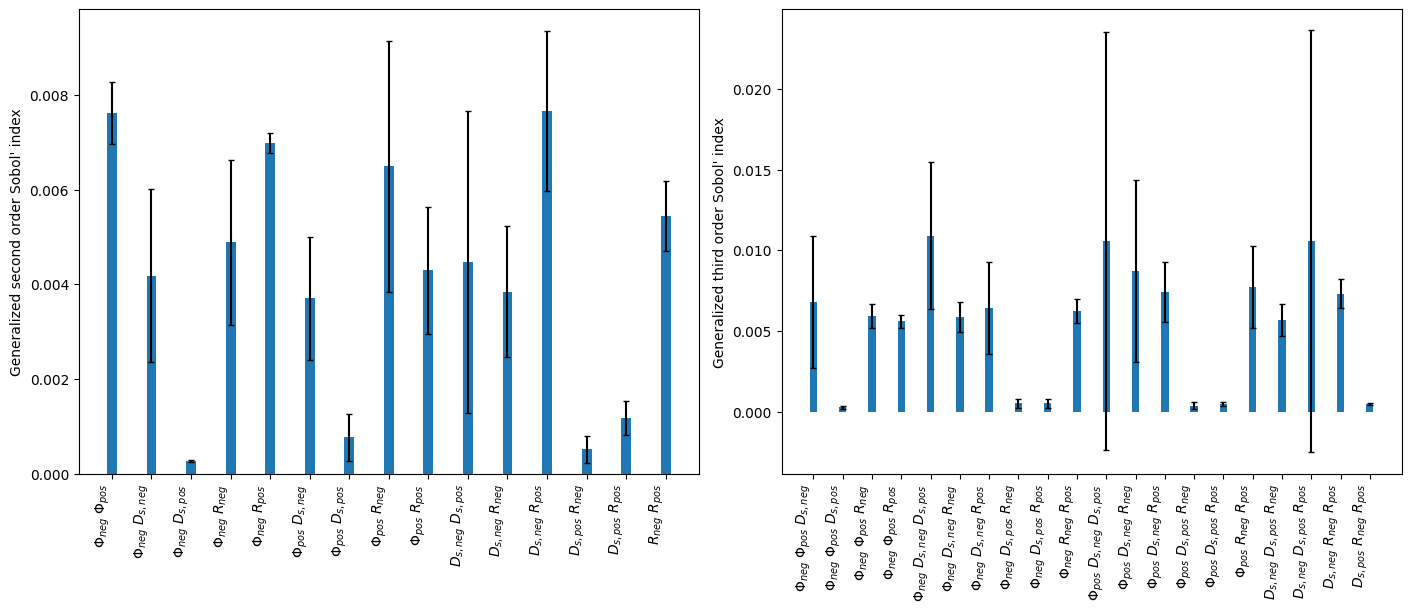

In [ ]:
fig, ax = plt.subplots(1,2, constrained_layout=True, figsize=(14,6))
x_sec = np.arange(len(param_combinations_sec))
x_third = np.arange(len(param_combinations_third))
ax[0].bar(x_sec, sobol_indices_second_PCE_mean, width=0.25, label="second order from PCE")
ax[0].errorbar(x_sec, sobol_indices_second_PCE_mean, yerr=sobol_indices_second_PCE_std, capsize=2.5, elinewidth=1.5, markeredgewidth=1, color="black", linestyle="None")
ax[1].bar(x_third, sobol_indices_third_PCE_mean, width=0.25, label="third order from PCE")
ax[1].errorbar(x_third, sobol_indices_third_PCE_mean, yerr=sobol_indices_third_PCE_std, capsize=2.5, elinewidth=1.5, markeredgewidth=1, color="black", linestyle="None")
ax[0].set_xticks(x_sec, param_combinations_sec, rotation=90, ha="right")
ax[0].set_ylabel("Generalized second order Sobol' index from PCE")
ax[1].set_xticks(x_third, param_combinations_third, rotation=90, ha="right")
ax[1].set_ylabel("Generalized third order Sobol' index from PCE")

In [ ]:
fig, ax = plt.subplots(1,2, constrained_layout=True, figsize=(14,6))
x_sec = np.arange(len(param_combinations_sec))
x_third = np.arange(len(param_combinations_third))
ax[0].bar(x_sec, sobol_indices_second_KL_mean, width=0.25, label="second order from KL")
ax[0].errorbar(x_sec, sobol_indices_second_KL_mean, yerr=sobol_indices_second_KL_std, capsize=2.5, elinewidth=1.5, markeredgewidth=1, color="black", linestyle="None")
ax[1].bar(x_third, sobol_indices_third_KL_mean, width=0.25, label="third order from KL")
ax[1].errorbar(x_third, sobol_indices_third_KL_mean, yerr=sobol_indices_third_KL_std, capsize=2.5, elinewidth=1.5, markeredgewidth=1, color="black", linestyle="None")
ax[0].set_xticks(x_sec, param_combinations_sec, rotation=90, ha="right")
ax[0].set_ylabel("Generalized second order Sobol' index from KL")
ax[1].set_xticks(x_third, param_combinations_third, rotation=90, ha="right")
ax[1].set_ylabel("Generalized third order Sobol' index from KL")

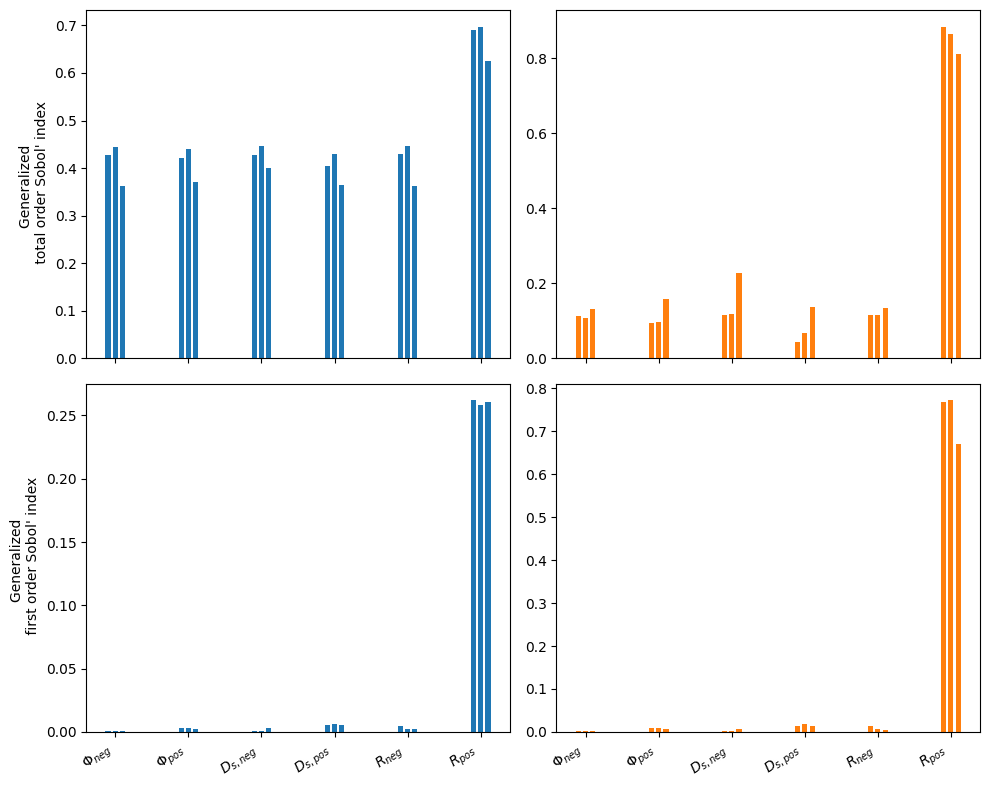

In [ ]:
fig, axes = plt.subplots(2,2, figsize=(10,8), sharex=True)
dist = np.linspace(-0.1, 0.1, 3) # -0.3, 0.3, 10
x = np.arange(len(my_tdsa.param_names))
for i in range(num_rounds):
    axes[0,0].bar(x+dist[i], sobol_indices_total_KL[i,:], width=0.07, color="tab:blue")
    axes[0,1].bar(x+dist[i], sobol_indices_total_PCE[i,:], width=0.07, color="tab:orange")
for i in range(num_rounds):
    axes[1,0].bar(x+dist[i], sobol_indices_first_KL[i,:], width=0.07, color="tab:blue")
    axes[1,1].bar(x+dist[i], sobol_indices_first_PCE[i,:], width=0.07, color="tab:orange")
axes[1,0].set_xticks(x, my_tdsa.param_names, rotation=35, ha="right")
axes[1,1].set_xticks(x, my_tdsa.param_names, rotation=35, ha="right")
axes[0,0].set_ylabel("Generalized \n total order Sobol' index")
axes[0,1].set_xticks(x, my_tdsa.param_names, rotation=35, ha="right")
axes[1,0].set_ylabel("Generalized \n first order Sobol' index")
plt.tight_layout()

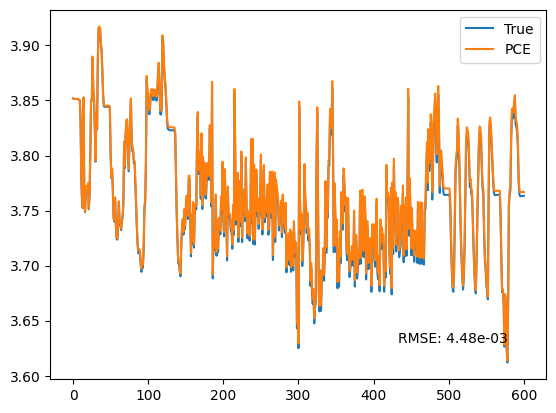

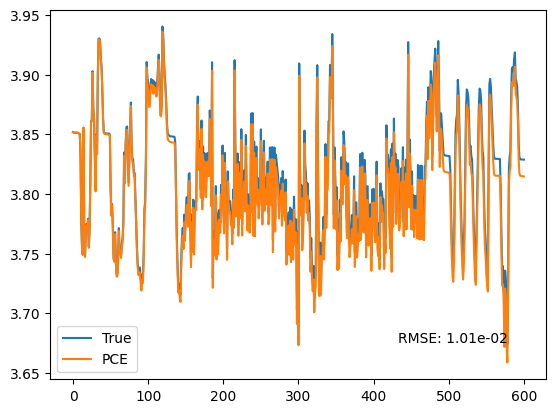

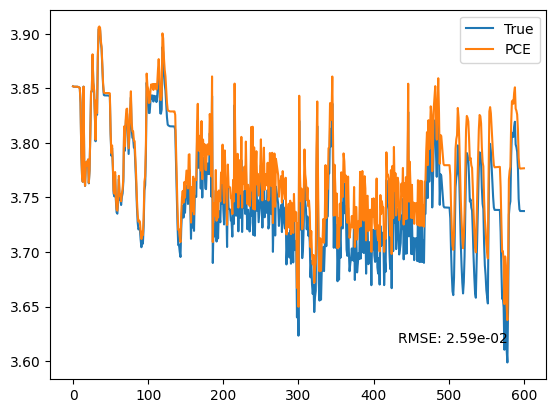

In [ ]:
## Test quality of PCE surrogate model

from sklearn.metrics import mean_squared_error

params = my_distribution.dist.sample(3).T

results = my_simulator.run(params)

result1 = results[0]
result2 = results[1]
result3 = results[2]

PCE_result1 = my_tdsa.evaluate_PCE_surrogate(params[0])
PCE_result2 = my_tdsa.evaluate_PCE_surrogate(params[1])
PCE_result3 = my_tdsa.evaluate_PCE_surrogate(params[2])

t_quad = np.linspace(t_sol[0],t_sol[-1], my_tdsa._num_timesteps_quadrature)

result1_interp = np.interp(t_quad, t_sol, result1)
result2_interp = np.interp(t_quad, t_sol, result2)
result3_interp = np.interp(t_quad, t_sol, result3)

rms1 = mean_squared_error(result1_interp, PCE_result1, squared=False)
rms2 = mean_squared_error(result2_interp, PCE_result2, squared=False)
rms3 = mean_squared_error(result3_interp, PCE_result3, squared=False)

plt.figure()
plt.plot(t_sol, result1, label="True")
plt.plot(t_quad, PCE_result1, label="PCE")
plt.text(0.7, 0.1, f"RMSE: {rms1:.2e}", transform=plt.gca().transAxes)
plt.legend()

plt.figure()
plt.plot(t_sol, result2, label="True")
plt.plot(t_quad, PCE_result2, label="PCE")
plt.text(0.7, 0.1, f"RMSE: {rms2:.2e}", transform=plt.gca().transAxes)
plt.legend()

plt.figure()
plt.plot(t_sol, result3, label="True")
plt.plot(t_quad, PCE_result3, label="PCE")
plt.text(0.7, 0.1, f"RMSE: {rms3:.2e}", transform=plt.gca().transAxes)
plt.legend()

In [ ]:
## See if fixing all but the least sensitive parameters leads to a variance that is lower than some percentage of the total variance

samples = my_distribution.sample(1000)

nominal_param_values = np.array([[0.375, 0.525, 5e-12, 5e-13, 0.7e-5, 0.55e-5]])
variable_por_pos = np.array([[0.375, sample[1], 5e-12, 5e-13, 0.7e-5, 0.55e-5] for sample in samples])

output_nominal_params = my_simulator.generate_output(nominal_param_values)
outputs_all_params = my_simulator.generate_output(samples)
outputs_por_pos = my_simulator.generate_output(variable_por_pos)


Text(0, 0.5, 'Counts')

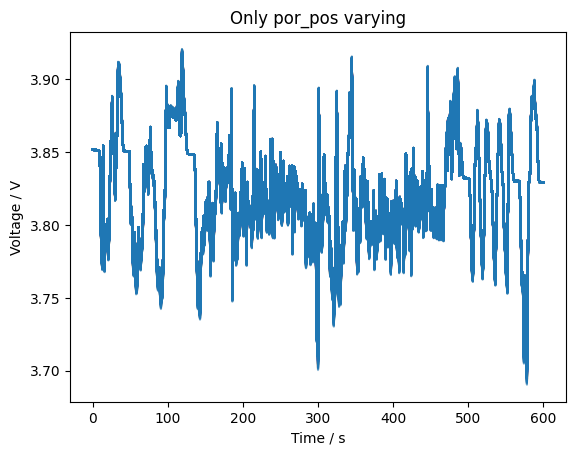

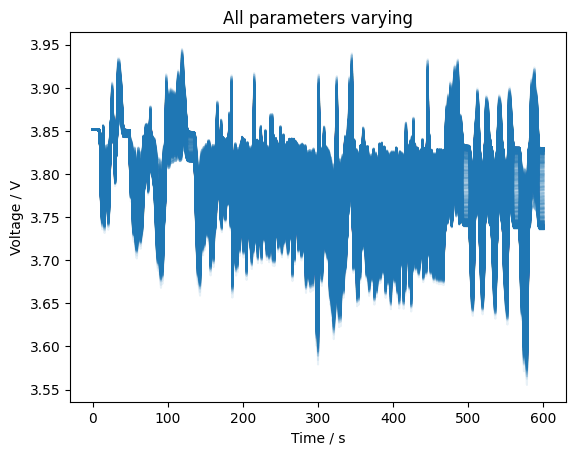

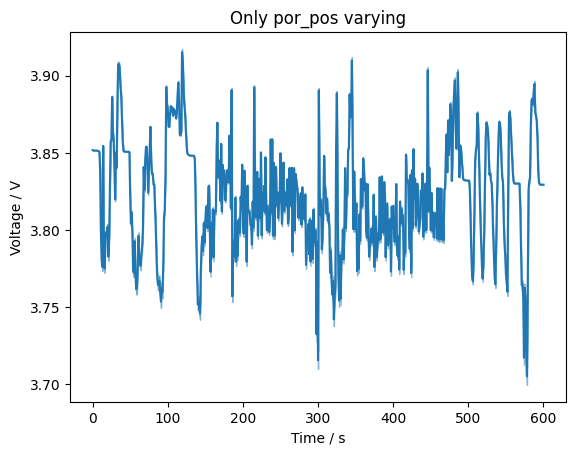

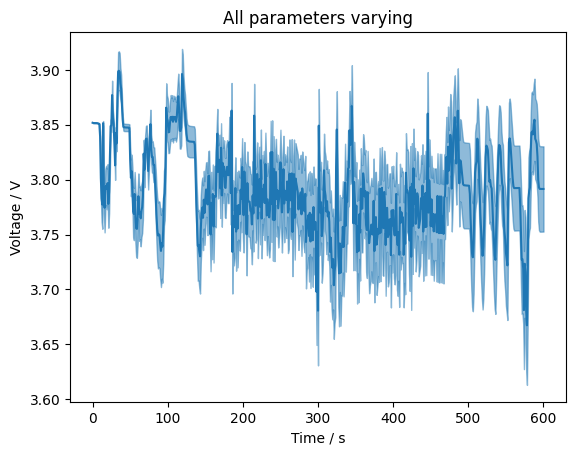

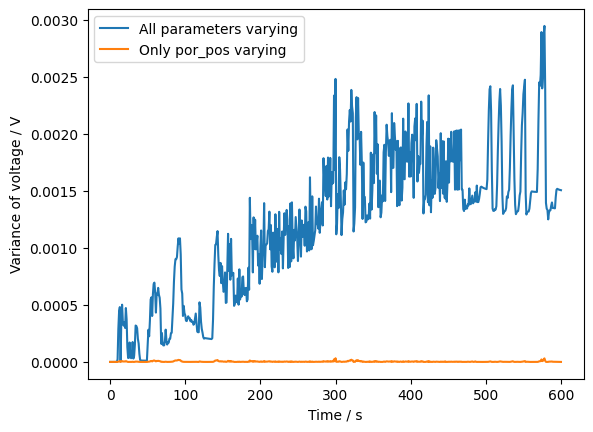

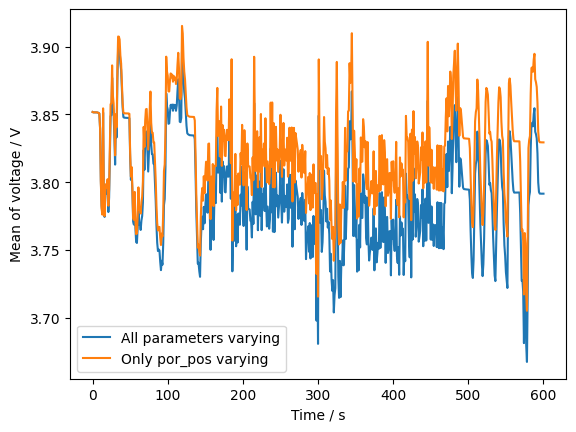

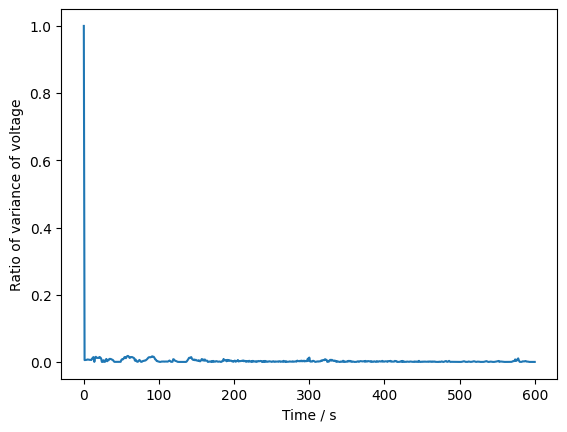

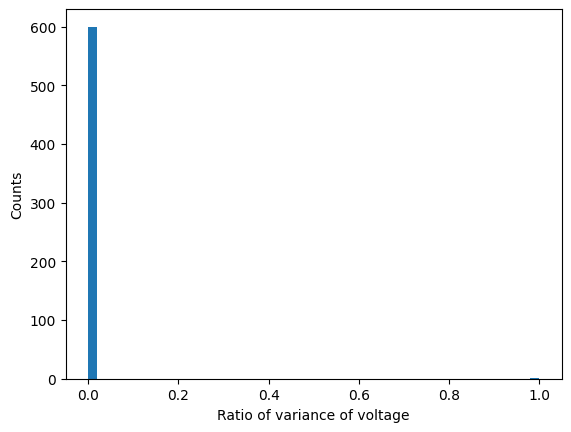

In [ ]:
plt.figure()
for output in outputs_por_pos:
    plt.plot(t_sol, output, alpha=0.1, color="tab:blue")
plt.xlabel("Time / s")
plt.ylabel("Voltage / V")
plt.title("Only por_pos varying")

plt.figure()
for output in outputs_all_params:
    plt.plot(t_sol, output, alpha=0.1, color="tab:blue")
plt.xlabel("Time / s")
plt.ylabel("Voltage / V")
plt.title("All parameters varying")

plt.figure()
plt.plot(t_sol, np.mean(outputs_por_pos, axis=0), color="tab:blue")
plt.fill_between(t_sol, np.mean(outputs_por_pos, axis=0) - np.std(outputs_por_pos, axis=0), np.mean(outputs_por_pos, axis=0) + np.std(outputs_por_pos, axis=0), color="tab:blue", alpha=0.5)
plt.xlabel("Time / s")
plt.ylabel("Voltage / V")
plt.title("Only por_pos varying")

plt.figure()
plt.plot(t_sol, np.mean(outputs_all_params, axis=0), color="tab:blue")
plt.fill_between(t_sol, np.mean(outputs_all_params, axis=0) - np.std(outputs_all_params, axis=0), np.mean(outputs_all_params, axis=0) + np.std(outputs_all_params, axis=0), color="tab:blue", alpha=0.5)
plt.xlabel("Time / s")
plt.ylabel("Voltage / V")
plt.title("All parameters varying")

plt.figure()
plt.plot(t_sol, np.var(outputs_all_params, axis=0), color="tab:blue", label="All parameters varying")
plt.plot(t_sol, np.var(outputs_por_pos, axis=0), color="tab:orange", label="Only por_pos varying")
plt.xlabel("Time / s")
plt.ylabel("Variance of voltage / V")
plt.legend()

plt.figure()
plt.plot(t_sol, np.mean(outputs_all_params, axis=0), color="tab:blue", label="All parameters varying")
plt.plot(t_sol, np.mean(outputs_por_pos, axis=0), color="tab:orange", label="Only por_pos varying")
plt.xlabel("Time / s")
plt.ylabel("Mean of voltage / V")
plt.legend()

plt.figure()
plt.plot(t_sol, np.var(outputs_por_pos, axis=0)/np.var(outputs_all_params, axis=0), color="tab:blue")
plt.xlabel("Time / s")
plt.ylabel("Ratio of variance of voltage")

plt.figure()
plt.hist(np.var(outputs_por_pos, axis=0)/np.var(outputs_all_params, axis=0), bins=50)
plt.xlabel("Ratio of variance of voltage")
plt.ylabel("Counts")